In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from utils import *


In [2]:
# Hyperparameters and paths

first_execution = False  # Set to True for the first execution to split the excel file

RAW = Path("data/raw/Observations_2012-2025.xlsx")
OUT_FILT = Path("data/filtered")
OUT_CLEAN = Path("data/cleaned")
OUT_DRAFT = Path("data/drafts")

sheets_to_csv_filtered = {
    "ESPECES": "especes.csv",
    "GPS-MILIEU": "gps_milieu.csv",
    "NOM FRANÇAIS": "observations.csv",
}

sheets_to_csv_cleaned = {
    "ESPECES": "especes_clean.csv",
    "GPS-MILIEU": "gps_milieu_clean.csv",
    "NOM FRANÇAIS": "nom_francais_clean.csv",
}


In [3]:
# Original sheets declaration : 

# Run on the first execution to split and save the excel file into multiple csv files
if first_execution:
    print(split_excel_to_csvs(RAW, OUT_FILT, sheets_to_csv_filtered))

# For following executions, load the csv files directly
dfs = load_csvs(OUT_FILT, sheets_to_csv_filtered)
for k, df in dfs.items():
    print(f"{k}: {df.shape}")


# Visual inspection of dataframes, uncoment as needed
# dfs['ESPECES'].head()
# dfs['GPS-MILIEU'].head()
# dfs['NOM FRANÇAIS'].head()

ESPECES: (86, 5)
GPS-MILIEU: (651, 8)
NOM FRANÇAIS: (114497, 26)


In [4]:
# Cleaned dataframes declaration 

if first_execution:
    # Cleaning dataframes from initial loading issues
    clean_especes = clean_especes(dfs["ESPECES"])
    clean_gps = clean_gps(dfs["GPS-MILIEU"])
    clean_nom_francais = clean_observations(dfs["NOM FRANÇAIS"])

    # Saving cleaned dataframes back to csv files
    save_clean_csvs({"ESPECES": clean_especes, "GPS-MILIEU": clean_gps, "NOM FRANÇAIS": clean_nom_francais}, OUT_CLEAN)

else:
    # Loading cleaned dataframes directly from csv files
    clean_dfs = load_csvs(OUT_CLEAN, sheets_to_csv_cleaned)
    clean_especes = clean_dfs["ESPECES"]
    clean_gps = clean_dfs["GPS-MILIEU"]
    clean_nom_francais = clean_dfs["NOM FRANÇAIS"]

# uncomment as needed to inspect cleaned dataframes
# clean_especes.head()
# clean_gps.head()
# clean_nom_francais.head()

In [5]:
clean_especes.head()

,ESPECIES_NAME,LATIN_NAME,NATURE
0,Aigrette bleue,Egretta caerulea,Migrateur
1,Aigrette garzette,Egretta garzetta,Migrateur
2,Aigrette neigeuse,Egretta thula,Migrateur
3,Aigrette tricolore,Egretta tricolor ruficollis,Migrateur
4,Amazone aourou,Amazona amazonica,Exogène introduit par l'homme


## Dataset orientation summaries

In [6]:
print("Data orientation summaries : ")
print(f"- Especes : {clean_especes.shape}")
print(f"- GPS : {clean_gps.shape}")
print(f"- Nom Français : {clean_nom_francais.shape}")

Data orientation summaries : 
- Especes : (87, 3)
- GPS : (650, 6)
- Nom Français : (114495, 26)


---

## Especes : 

In [7]:
df = clean_especes.copy()

# Basic structure and uniqueness check ------------------------------------
print("Number of species:", len(df))
print("Unique ESPECIES_NAME:", df["ESPECIES_NAME"].nunique())
print("Unique LATIN_NAME:", df["LATIN_NAME"].nunique())

# Check for duplicates
dup_species = df[df["ESPECIES_NAME"].duplicated(keep=False)].sort_values("ESPECIES_NAME")
dup_latin   = df[df["LATIN_NAME"].duplicated(keep=False)].sort_values("LATIN_NAME")

print("Duplicated:")
display(dup_species)


Number of species: 87
Unique ESPECIES_NAME: 86
Unique LATIN_NAME: 86
Duplicated:


,ESPECIES_NAME,LATIN_NAME,NATURE
7,Astrild ondulé,Estrilda astrild,Exogène introduit par l'homme
8,Astrild ondulé,Estrilda astrild,Exogène introduit par l'homme


In [8]:
# "Families" aer defined by a shared root ------------------------------------
df["ESPECIES_FAMILY"] = df["ESPECIES_NAME"].str.split().str[0]
df["LATIN_FAMILY"] = df["LATIN_NAME"].str.split().str[0]

# Count distinct families
especies_families = df["ESPECIES_FAMILY"].value_counts().reset_index()
especies_families.columns = ["ESPECIES_FAMILY", "N_ESPECIES"]

latin_families = df["LATIN_FAMILY"].value_counts().reset_index()
latin_families.columns = ["LATIN_FAMILY", "N_ESPECIES"]
    
# Also build Python dictionaries
species_family_dict = dict(zip(especies_families["ESPECIES_FAMILY"], especies_families["N_ESPECIES"]))
latin_family_dict = dict(zip(latin_families["LATIN_FAMILY"], latin_families["N_ESPECIES"]))

print("French name families (count):", len(species_family_dict))
print("Latin name families (count):", len(latin_family_dict))

print("Top 10 families (by French names):")
display(especies_families.head(10))
print("Top 10 families (by Latin names):")
display(latin_families.head(10))


French name families (count): 53
Latin name families (count): 71
Top 10 families (by French names):


,ESPECIES_FAMILY,N_ESPECIES
0,Aigrette,4
1,Astrild,4
2,Colibri,4
3,Chevalier,4
4,Moqueur,4
5,Sterne,4
6,Sporophile,3
7,Hirondelle,3
8,Tourterelle,3
9,Colombe,3


Top 10 families (by Latin names):


,LATIN_FAMILY,N_ESPECIES
0,Egretta,4
1,Estrilda,4
2,Tringa,3
3,Falco,3
4,Eulampis,2
5,Lonchura,2
6,Geotrygon,2
7,Onychoprion,2
8,Ardea,2
9,Zenaida,2


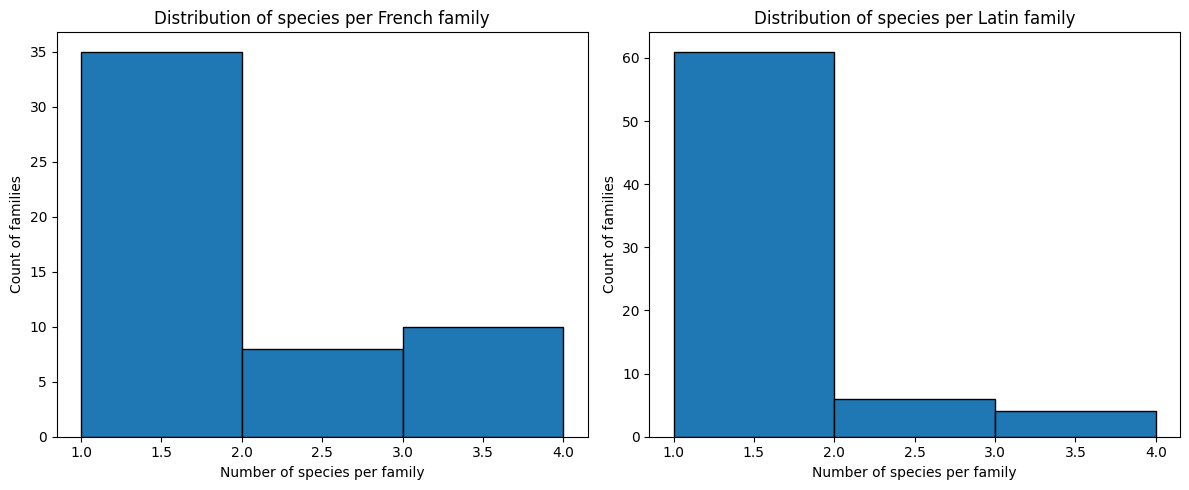

In [9]:
# Plot distribution of family sizes ------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(especies_families["N_ESPECIES"], bins=range(1, especies_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[0].set_title("Distribution of species per French family")
axes[0].set_xlabel("Number of species per family")
axes[0].set_ylabel("Count of families")

axes[1].hist(latin_families["N_ESPECIES"], bins=range(1, latin_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[1].set_title("Distribution of species per Latin family")
axes[1].set_xlabel("Number of species per family")
axes[1].set_ylabel("Count of families")
plt.tight_layout()
plt.show()



Distinct NATURE values:
NATURE
Migrateur                         24
Autochtone                        19
Exogène introduit par l'homme     15
Endémique des Petites Antilles    13
Marin                              8
Exogène colonisateur naturel       4
Endémique de la Martinique         2
Migrateur rare                     1
Name: count, dtype: int64
Nature distribution per family:


,ESPECIES_FAMILY,NATURE,count
0,Aigrette,Migrateur,4
1,Amazone,Exogène introduit par l'homme,1
2,Astrild,Exogène introduit par l'homme,3
3,Balbuzard,Migrateur,1
4,Bengali,Exogène introduit par l'homme,1
5,Bihoreau,Autochtone,1
6,Bihoreau,Migrateur,1
7,Bécasseau,Migrateur,1
8,Canard,Exogène introduit par l'homme,1
9,Capucin,Exogène introduit par l'homme,2


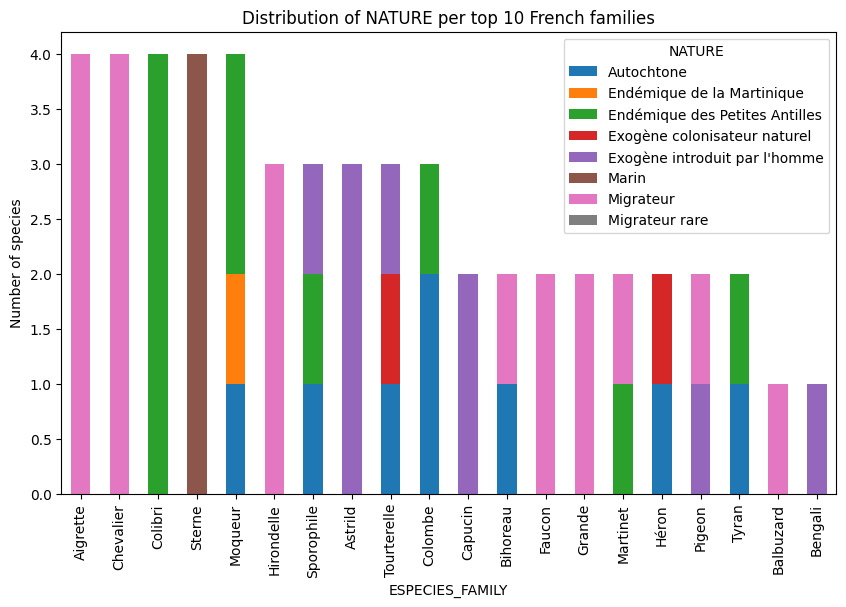

In [10]:
# NATURE analysis ------------------------------------
print("Distinct NATURE values:")
print(df["NATURE"].value_counts())

# Distribution of NATURE per family ------------------------------------
nature_by_family = (
    df.groupby(["ESPECIES_FAMILY", "NATURE"])
      .size()
      .reset_index(name="count")
)

print("Nature distribution per family:")
display(nature_by_family.sort_values(["ESPECIES_FAMILY", "count"], ascending=[True, False]).head(10))

# Pivot to make a clearer table
nature_pivot = nature_by_family.pivot_table(
    index="ESPECIES_FAMILY", columns="NATURE", values="count", fill_value=0
).astype(int)

# Plot top 10 families by total species
top_fams = nature_pivot.sum(axis=1).sort_values(ascending=False).head(20).index
nature_pivot.loc[top_fams].plot(
    kind="bar", stacked=True, figsize=(10, 6),
    title="Distribution of NATURE per top 10 French families"
)
plt.ylabel("Number of species")
plt.show()


#### Key insights for the ESPECES table :

TBD 

---

- GPS :

In [13]:
df = clean_gps.copy()

# Count distinct habitat types ------------------------------------
n_habitats = df["HABITAT_TYPE"].nunique()
print(f"Number of distinct habitat types: {n_habitats}")
print("Habitat types frequency:")
print(df["HABITAT_TYPE"].value_counts())

# Link habitat types to unique transect names ------------------------------------
# Remove duplicates so that each (habitat, transect_name) pair appears only once
habitat_transect = (
    df[["HABITAT_TYPE", "TRANSECT_NAME"]]
    .drop_duplicates()
    .sort_values(["HABITAT_TYPE", "TRANSECT_NAME"])
)

# For each habitat type, list unique transects
habitat_to_transects = (
    habitat_transect.groupby("HABITAT_TYPE")["TRANSECT_NAME"]
    .apply(list)
    .to_dict()
)

# Display summary ------------------------------------
print("Habitat type → number of unique transects:")
for habitat, transects in habitat_to_transects.items():
    print(f"- {habitat}: {len(transects)} transects")


Number of distinct habitat types: 7
Habitat types frequency:
HABITAT_TYPE
Forêt sèche     186
Agricole        134
Forêt humide    130
Périurbain      120
Mangrove         30
Plage            30
Urbain           20
Name: count, dtype: int64
Habitat type → number of unique transects:
- Agricole: 14 transects
- Forêt humide: 13 transects
- Forêt sèche: 19 transects
- Mangrove: 3 transects
- Plage: 3 transects
- Périurbain: 12 transects
- Urbain: 2 transects


In [14]:
print(70*"=")
# Optional: show a few examples
for habitat, transects in list(habitat_to_transects.items()):
    print(f"\n{habitat} ({len(transects)} transects):")
    print(transects)

# make a summary DataFrame and plot ------------------------------------
habitat_summary = (
    pd.DataFrame({
        "HABITAT_TYPE": list(habitat_to_transects.keys()),
        "N_TRANSECTS": [len(v) for v in habitat_to_transects.values()]
    })
    .sort_values("N_TRANSECTS", ascending=False)
)


Agricole (14 transects):
['Bois Pothau', 'Canal Cocotte', 'Cap Est', 'Carrère', 'Fonds Préville', 'Galion', 'Galion 2', 'Génipa', 'Habitation Petite Rivière', 'Hôtel des Plaisirs', 'Lafayette', 'Morne Babet', 'Moulin à Vent', 'Verrier']

Forêt humide (13 transects):
['Anse Couleuvre', 'Bois La Charles', 'Bouliki', "Domaine d'Emeraude", 'Fond Baron', "Fond l'Etang", 'Forêt Montravail', 'Forêt la Reculée', 'La Démarche 2', "Rivière l'Or", 'Route Forestière de Palourde', 'Tunnel Didier', 'Tunnel Didier 2']

Forêt sèche (19 transects):
['Anse Mathurin', 'Blin', 'Bois Pothau', 'Forêt Vatable', 'Forêt Vatable 2', 'Forêt la Philippe', 'Ilets du François', 'Ilets du Robert', 'Le Phare-Caravelle', 'Morne Bellevue', 'Morne Gardier', 'Petit Sentier RNC', 'Piton Crève-cœur', 'Pointe Banane', 'Pointe Jean-Claude', 'Pointe La Rose', 'Pointe Lynch', 'Pointe Rouge', 'Rocher Leclerc']

Mangrove (3 transects):
['Aéroport', 'Boucle du Vauclin', 'Morne Cabri']

Plage (3 transects):
['Anse Meunier', 'Autr

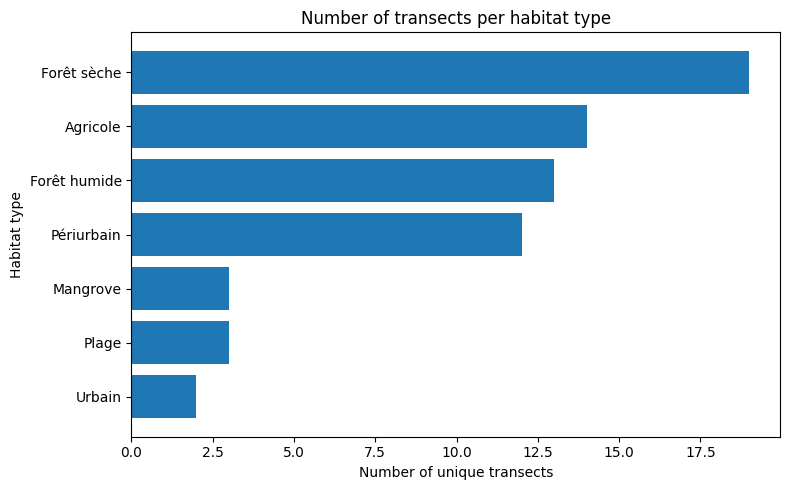

In [ ]:
# Bar plot: how many transects per habitat type

plt.figure(figsize=(8, 5))
plt.barh(habitat_summary["HABITAT_TYPE"], habitat_summary["N_TRANSECTS"])
plt.xlabel("Number of unique transects")
plt.ylabel("Habitat type")
plt.title("Number of transects per habitat type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Key insights for the GPS-MILIEU table :

TBD 

---

### Nom Français : 

,year,N_observations,N_species,Total_birds,Mean_birds_per_obs
0,2014.0,5378,64,11217.000000,2.085720
1,2015.0,8162,70,17815.000000,2.182676
2,2016.0,11011,78,23285.000000,2.114703
3,2017.0,9228,71,20644.809524,2.237192
4,2018.0,9733,73,20556.000000,2.111990
5,2019.0,9572,70,21196.333333,2.214410
6,2020.0,9956,68,22199.000000,2.229711
7,2021.0,10604,69,24220.000000,2.284044
8,2022.0,10804,68,24714.000000,2.287486
9,2023.0,10224,67,22545.000000,2.205106


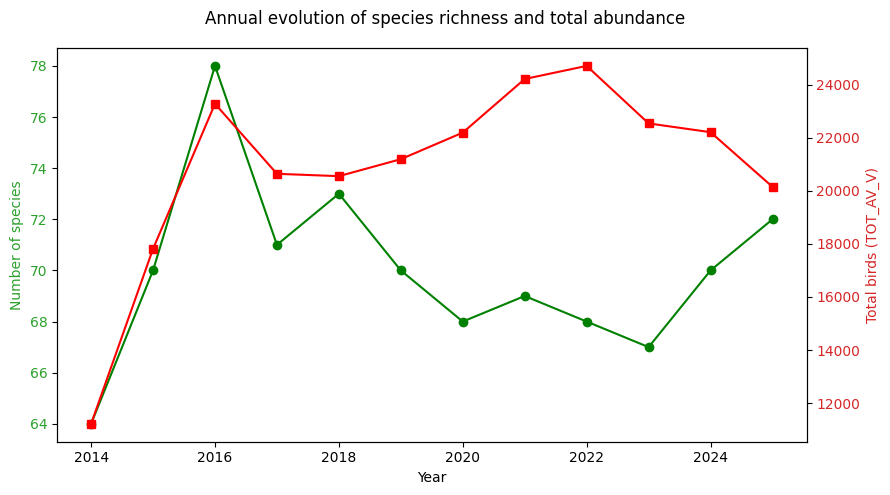

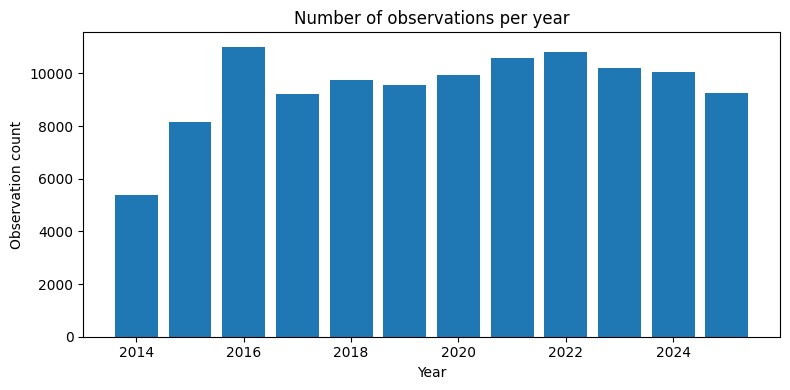

In [20]:
# Assume the cleaned observations table is already loaded:
# df_obs = pd.read_csv("data/filtered/observations_clean.csv")

df = clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Basic yearly counts ---
annual_summary = (df.groupby("year").agg(
          N_observations=("ESPECE", "size"),
          N_species=("ESPECE", "nunique"),
          Total_birds=("TOT_AV_V", "sum"),
          Mean_birds_per_obs=("TOT_AV_V", "mean")
        ).reset_index()
)

display(annual_summary)

# --- Plot species richness and total abundance per year ---
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(annual_summary["year"], annual_summary["N_species"], marker="o", color="green", label="Species richness")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of species", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")

ax2 = ax1.twinx()
ax2.plot(annual_summary["year"], annual_summary["Total_birds"], marker="s", color="red", label="Total birds")
ax2.set_ylabel("Total birds (TOT_AV_V)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("Annual evolution of species richness and total abundance")
plt.tight_layout()
plt.show()

# --- Histogram: number of observations per year ---
plt.figure(figsize=(8,4))
plt.bar(annual_summary["year"], annual_summary["N_observations"], color="tab:blue")
plt.title("Number of observations per year")
plt.xlabel("Year")
plt.ylabel("Observation count")
plt.tight_layout()
plt.show()


,Nom observateur,N_observations,N_years,N_species_seen,Mean_birds,Total_birds
19,CONDE Beatriz,41435,12,79,2.198439,91092.333333
6,BAHUAUD Anthony,8719,10,65,2.154949,18789.000000
10,BELFAN David,7331,12,48,2.924703,21441.000000
36,MAUGEE Lévy,6838,12,47,2.068587,14145.000000
5,AUGUSTE Christophe,5054,12,40,1.700200,8592.809524
35,MARRAUD des GROTTES Roland,4229,12,40,1.551904,6563.000000
3,ALEXANDRINE Thomas,3154,12,30,1.679455,5297.000000
40,PICARD Rémi,3116,4,44,2.561938,7983.000000
38,MOURIESSE Jocelyne,3093,12,47,2.354672,7283.000000
47,VALSIN Michel,2284,9,40,2.577496,5887.000000


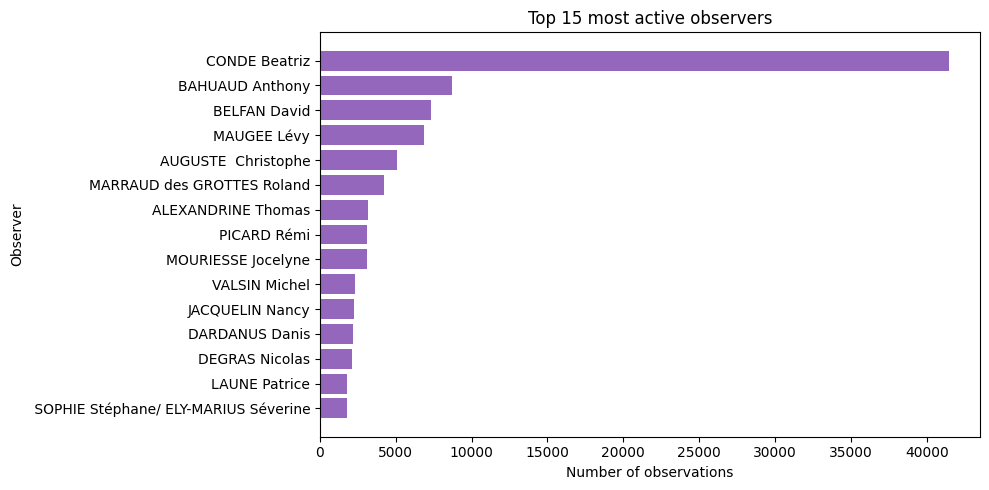

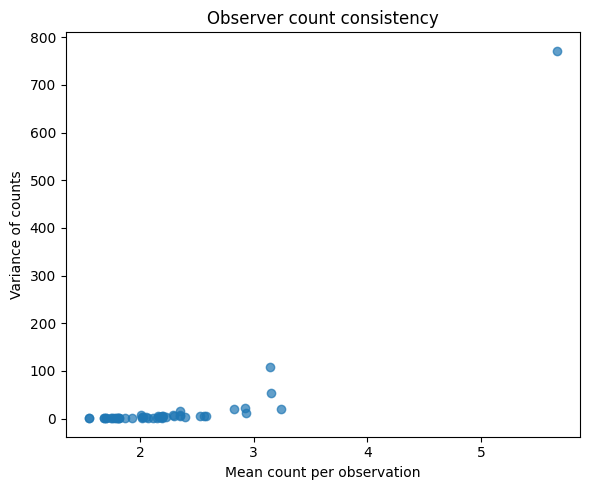

,Nom observateur,Mean_count,Variance,count
2,AGAT Arnaud-FREMACX Vincent- NOSEL Christopher,5.666667,771.626667,51
11,BELLUMEUR Wilfrid,3.142857,107.331800,1554
43,ROLLIN Michaël,3.149718,53.765057,354
10,BELFAN David,2.924703,21.324207,7331
28,FLERIAG Lyneda,2.832011,20.783663,756
32,LABONNE Annick,3.243011,20.399870,465
38,MOURIESSE Jocelyne,2.354672,15.801399,3093
31,JACQUELIN Nancy,2.934938,11.072002,2244
18,CHANTEUR Bénédicte,2.293651,7.877812,504
20,CONDE Beatriz,2.350725,7.181867,345


In [21]:
# --- Observer participation summary ---
observer_summary = (
    df.groupby("Nom observateur")
      .agg(
          N_observations=("ESPECE", "size"),
          N_years=("year", "nunique"),
          N_species_seen=("ESPECE", "nunique"),
          Mean_birds=("TOT_AV_V", "mean"),
          Total_birds=("TOT_AV_V", "sum")
      )
      .reset_index()
      .sort_values("N_observations", ascending=False)
)

display(observer_summary.head(10))

# --- Plot: top observers by number of observations ---
plt.figure(figsize=(10,5))
top_obs = observer_summary.head(15)
plt.barh(top_obs["Nom observateur"], top_obs["N_observations"], color="tab:purple")
plt.xlabel("Number of observations")
plt.ylabel("Observer")
plt.title("Top 15 most active observers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Observer consistency: mean vs variance of counts ---
# (A simple reliability proxy — stable observers have low variance in total counts)
observer_variability = (
    df.groupby("Nom observateur")["TOT_AV_V"]
      .agg(["mean", "var", "count"])
      .rename(columns={"mean": "Mean_count", "var": "Variance"})
      .reset_index()
)

plt.figure(figsize=(6,5))
plt.scatter(observer_variability["Mean_count"], observer_variability["Variance"], alpha=0.7)
plt.xlabel("Mean count per observation")
plt.ylabel("Variance of counts")
plt.title("Observer count consistency")
plt.tight_layout()
plt.show()

# Observers with very high variance relative to mean may indicate inconsistent detection
display(observer_variability.sort_values("Variance", ascending=False).head(10))


In [ ]:

# Assume df_obs is your cleaned observations DataFrame
df = clean_nom_francais.copy()

# Unique mapping of observer ↔ transect (ignoring point duplicates)
observer_transect = (
    df[["Nom observateur", "Nom transect"]]
    .drop_duplicates()
    .sort_values(["Nom observateur", "Nom transect"])
)

print(f"Total unique observer-transect pairs: {len(observer_transect)}")
display(observer_transect.head(10))

# For each observer, list all transects they have worked on
observer_to_transects = (
    observer_transect.groupby("Nom observateur")["Nom transect"]
    .apply(list)
    .to_dict()
)

# Example output: {"Alice": ["Transect_1", "Transect_4"], "Bob": ["Transect_2"], ...}
print("Example observer to transects mapping:")
for k, v in list(observer_to_transects.items())[:5]:
    print(f"- {k}: {len(v)} transects → {v[:5]}")


Total unique observer–transect pairs: 142


,Nom observateur,Nom transect
82826,SOPHIE Stéphane/ ELY-MARIUS Séverine,Habitation Petite Rivière
76732,SOPHIE Stéphane/ ELY-MARIUS Séverine,Moulin à Vent
18582,VALSIN Michel,Morne Bellevue
109532,AGAT Arnaud-FREMACX Vincent- NOSEL Christopher,Ilets du François
47188,ALEXANDRINE Thomas,Le Phare-Caravelle
4919,ALEXANDRINE Thomas,Petit Sentier RNC
4867,ALEXANDRINE Thomas,Pointe Rouge
113860,ALEXANDRINE Thomas,Le Phare-Caravelle
113815,ALEXANDRINE Thomas,Petit Sentier RNC
113961,ALEXANDRINE Thomas,Pointe Rouge


Example observer to transects mapping:
-  SOPHIE Stéphane/ ELY-MARIUS Séverine: 2 transects → ['Habitation Petite Rivière', 'Moulin à Vent']
-  VALSIN Michel: 1 transects → ['Morne Bellevue']
- AGAT Arnaud-FREMACX Vincent- NOSEL Christopher: 1 transects → ['Ilets du François']
- ALEXANDRINE Thomas: 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']
- ALEXANDRINE Thomas : 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']


In [23]:
observer_to_transects

{' SOPHIE Stéphane/ ELY-MARIUS Séverine': ['Habitation Petite Rivière',
  'Moulin à Vent'],
 ' VALSIN Michel': ['Morne Bellevue'],
 'AGAT Arnaud-FREMACX Vincent- NOSEL Christopher': ['Ilets du François'],
 'ALEXANDRINE Thomas': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'ALEXANDRINE Thomas ': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'AUGUSTE  Christophe': ['ANSE COULEUVRE',
  'Anse Couleuvre',
  "Domaine d'Emeraude",
  'Fond Baron',
  'Fond Baron ',
  'Route Forestière de Palourde'],
 'BAHUAUD Anthony': ['Bouliki',
  'Canal Cocotte',
  'Desmarinière',
  'Desmarinières',
  'Génipa',
  'Lafayette',
  'Là-Haut'],
 'BAHUAUD Anthony ': ['Génipa', 'Là-Haut'],
 'BARBET Christophe': ['Bouliki'],
 'BATIFOULIER Sébastien': ['Fonds Préville', 'Forêt La Philippe'],
 'BELFAN David': ["Fond l'Etang",
  'Fort de France Centre Ville',
  'Pointe La Rose',
  'Tunnel Didier',
  'Tunnel Didier ',
  'Tunnel Didier 2'],
 'BELLUMEUR Wilfrid': ['Ilets du Robert'

In [25]:
# Count total observations (rows) per observer
obs_per_observer = (
    df.groupby("Nom observateur")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("\\nTop 10 most active observers:")
display(obs_per_observer.head(10))

# Count total observations per transect
obs_per_transect = (
    df.groupby("Nom transect")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("\\nTop 10 most observed transects:")
display(obs_per_transect.head(10))



\nTop 10 most active observers:


,Nom observateur,N_observations
19,CONDE Beatriz,41435
6,BAHUAUD Anthony,8719
10,BELFAN David,7331
36,MAUGEE Lévy,6838
5,AUGUSTE Christophe,5054
35,MARRAUD des GROTTES Roland,4229
3,ALEXANDRINE Thomas,3154
40,PICARD Rémi,3116
38,MOURIESSE Jocelyne,3093
47,VALSIN Michel,2284


\nTop 10 most observed transects:


,Nom transect,N_observations
50,Morne Babet,2878
38,Habitation Petite Rivière,2821
55,Moulin à Vent,2792
47,Là-Haut,2383
39,Hôtel des Plaisirs,2366
4,Autre Bord,2334
11,Borelie,2287
24,Fond Rousseau,2253
42,Jeannot,2222
56,O'Mullane,2203


In [28]:
# Extract year from date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Ensure weather covariates are numeric (in case they were strings)
weather_cols = ["nuages", "pluie", "vent", "visibilité"]
df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors="coerce")

transect_year_stats = (
    df.groupby(["Nom transect", "year"])[weather_cols]
      .mean()
      .reset_index()
)

# Add number of observations for each transect-year
transect_obs_count = (
    df.groupby(["Nom transect", "year"])
      .size()
      .reset_index(name="N_observations")
)
transect_year_stats = transect_year_stats.merge(transect_obs_count, on=["Nom transect", "year"])

display(transect_year_stats.head(10))


,Nom transect,year,nuages,pluie,vent,visibilité,N_observations
0,ANSE COULEUVRE,2019.0,1.757282,1.213592,1.339806,1.582524,103
1,Anse Couleuvre,2014.0,1.750000,1.086538,1.250000,1.423077,104
2,Anse Couleuvre,2015.0,1.892562,1.057851,2.000000,2.000000,121
3,Anse Couleuvre,2016.0,2.228070,1.087719,1.061404,1.447368,114
4,Anse Couleuvre,2017.0,1.978495,1.204301,1.000000,1.634409,93
5,Anse Couleuvre,2018.0,1.220930,1.034884,1.000000,1.139535,86
6,Anse Couleuvre,2020.0,2.000000,1.207547,1.886792,1.735849,53
7,Anse Couleuvre,2021.0,1.517241,1.189655,1.000000,1.344828,116
8,Anse Couleuvre,2022.0,3.000000,1.769231,2.175824,2.505495,91
9,Anse Couleuvre,2023.0,2.000000,1.310924,2.134454,1.689076,119


,ESPECE,year,N_observations
0,Aigrette bleue,2014.0,1
1,Aigrette bleue,2015.0,2
2,Aigrette bleue,2016.0,3
3,Aigrette bleue,2020.0,3
4,Aigrette bleue,2024.0,1
5,Aigrette neigeuse,2014.0,6
6,Aigrette neigeuse,2015.0,13
7,Aigrette neigeuse,2016.0,23
8,Aigrette neigeuse,2017.0,17
9,Aigrette neigeuse,2018.0,25


,ESPECE,N_years_observed
1,Aigrette neigeuse,12
3,Amazone aourou,12
20,Chevalier grivelé,12
17,Capucin à tête blanche,12
12,Bihoreau violacé,12
8,Astrild à joues orange,12
7,Astrild ondulé,12
27,Colombe rouviolette,12
35,Elénie siffleuse,12
32,Coulicou manioc,12


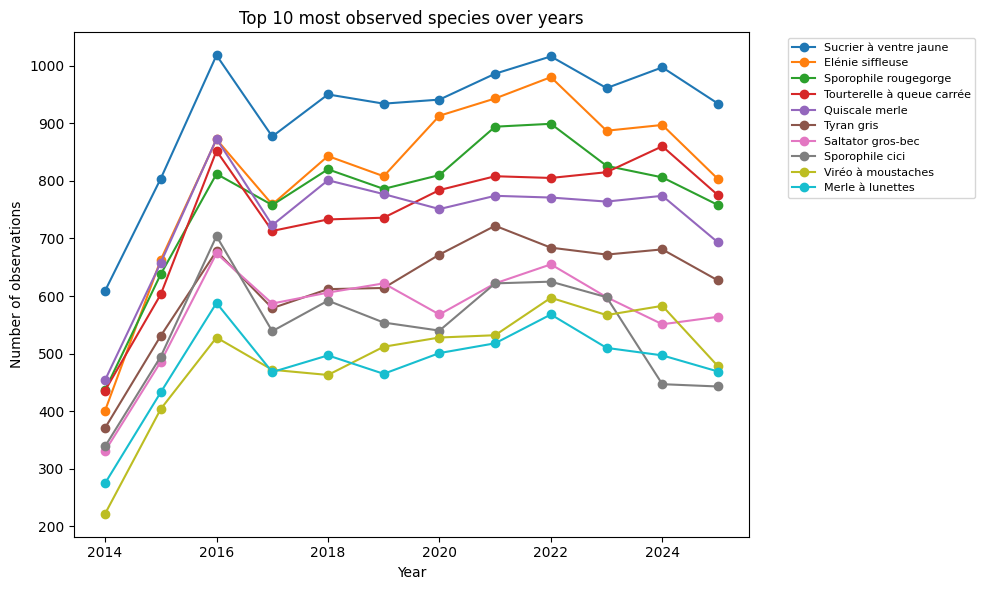

In [30]:

# Assume you have:
# df_obs = pd.read_csv("data/filtered/observations_clean.csv")
# df_especes = pd.read_csv("data/filtered/especes_clean.csv")

df = clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Count number of observations per species per year ---
species_year_counts = (
    df.groupby(["ESPECE", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["ESPECE", "year"])
)

display(species_year_counts.head(10))

# --- Total number of years each species was observed ---
species_total = (
    species_year_counts.groupby("ESPECE")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(species_total.head(10))

# --- Example: plot top 10 most observed species over time ---
top_species = (
    species_year_counts.groupby("ESPECE")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for specie in top_species:
    subset = species_year_counts[species_year_counts["ESPECE"] == specie]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=specie)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed species over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


,FAMILY,year,N_observations
0,Aigrette,2014.0,7
1,Aigrette,2015.0,15
2,Aigrette,2016.0,26
3,Aigrette,2017.0,17
4,Aigrette,2018.0,25
5,Aigrette,2019.0,26
6,Aigrette,2020.0,21
7,Aigrette,2021.0,15
8,Aigrette,2022.0,15
9,Aigrette,2023.0,17


,FAMILY,N_years_observed
0,Aigrette,12
1,Amazone,12
2,Astrild,12
5,Bihoreau,12
19,Gallinule,12
10,Colibri,12
9,Chevalier,12
8,Capucin,12
11,Colombe,12
18,Frégate,12


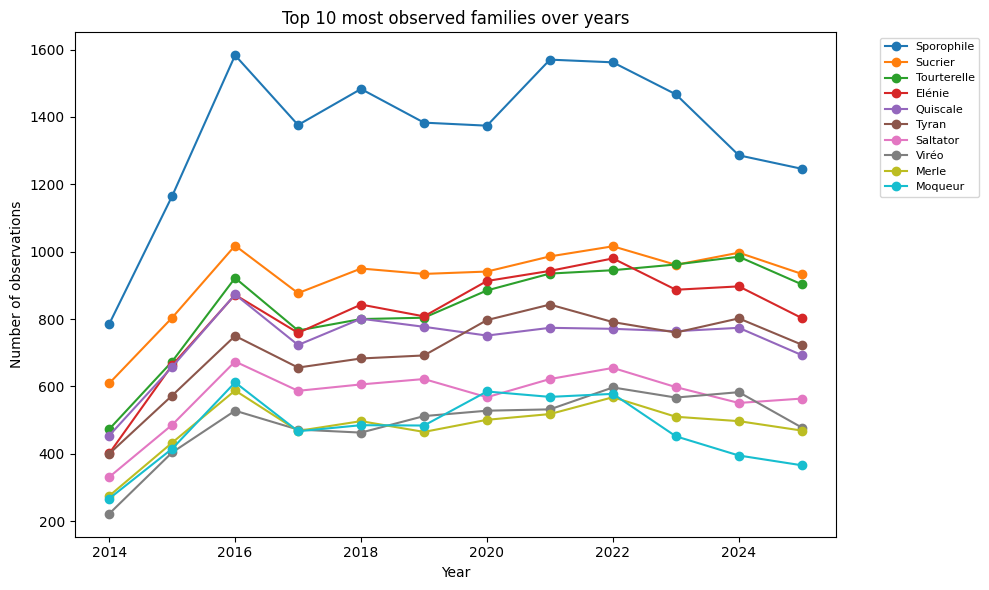

In [31]:
# Create mapping ESPECE (name) → family
clean_especes["ESPECIES_FAMILY"] = clean_especes["ESPECIES_NAME"].str.split().str[0]
species_to_family = dict(zip(clean_especes["ESPECIES_NAME"], clean_especes["ESPECIES_FAMILY"]))

# Map to observations table
df["FAMILY"] = df["ESPECE"].map(species_to_family)

# --- Count observations per family per year ---
family_year_counts = (
    df.groupby(["FAMILY", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["FAMILY", "year"])
)

display(family_year_counts.head(10))

# --- Total number of years each family observed ---
family_total = (
    family_year_counts.groupby("FAMILY")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(family_total.head(10))

# --- Plot top 10 most observed families ---
top_families = (
    family_year_counts.groupby("FAMILY")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for fam in top_families:
    subset = family_year_counts[family_year_counts["FAMILY"] == fam]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=fam)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed families over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


#### Key insights for the NOM_FRANÇAIS table :

TBD 